In [6]:
!pip install -q transformers==4.18.0
!pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
#ENTITY TYPE ANALYSIS for BIOSSES on ItsIRL model with different threshholds for ET sparsity

import gdown
import glob
import numpy as np
import os
import pandas as pd
import time
import torch
import torch.nn as nn
from transformers import AutoConfig
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

# 0: Get data

In [9]:
def get_copy_of_orig_models():
  f = '0518_prior_ier_frozen_with_ffn_200eps_1300000.pt'
  os.system("cp "+f+" orig_0518_itsirl.pt")
  f2 = "bs_0603_ft_60eps_1p5e5_ffn_0518_best_mse.pt"
  os.system("cp "+f2+" orig_0518_itsirl_ffn.pt")
  e2 = "bs_0602_e2e_redo_60eps_3e5_ffn_0518_best_mse.pt"
  os.system("cp "+e2+" orig_0518_itsirl_e2e.pt")

def copy_over_orig_models():
  f = '0518_prior_ier_frozen_with_ffn_200eps_1300000.pt'
  os.system("cp orig_0518_itsirl "+f)
  f2 = "bs_0603_ft_60eps_1p5e5_ffn_0518_best_mse.pt"
  os.system("cp orig_0518_itsirl_ffn.pt "+f2)
  e2 = "bs_0602_e2e_redo_60eps_3e5_ffn_0518_best_mse.pt"
  os.system("cp orig_0518_itsirl_e2e.pt "+e2)

def download_data(gid, out, quiet=True):
  gdown.download("https://drive.google.com/uc?id="+gid, out, quiet)

def cp_external_models():
  #os.system("rm bs_*")
  #os.system("rm 0518*")

  m1 = "0518_prior_ier_frozen_with_ffn_200eps_1300000.pt"
  #m1id = "1HwNuYmTaVVGJvC-aJQp0ZIXc-ClcjFAj"
  m1id = "1lH1euXM02a11pjL5DVwqDVlK757tttVR"
  download_data(m1id, m1, quiet=False) 

  f3 = "bs_0603_ft_60eps_1p5e5_ffn_0518_best_mse.pt"
  #f3id = "1AytqJKYXI-T_dJ63gmpRLDHE4vxWbMRC"
  f3id = "1rjLUptGO6Yf9PJWJ_d51y-Fzyixl5n6g"
  download_data(f3id, f3, quiet=False)

  e2 = "bs_0602_e2e_redo_60eps_3e5_ffn_0518_best_mse.pt"
  #e2id = "1fOHCVK0gfvuwUcdMkigMu7OHIIEI8nwP"
  e2id = "1WdCGEE413d0VRLd7h31UOU9PeZ9TWMBG"
  download_data(e2id, e2, quiet=False)  

In [41]:
#0. get ItsIRL predictions from models fine tuned on biosses data ( either end2end or decoder only)
#   unfortunately predictions don't include entity type layers, so we need to get model checkpoints
#   and regenerate the entity types as well 
cp_external_models()

# 1) FFN: bs_0603_ft_60eps_1p5e5_ffn_0518  ...https://wandb.ai/diegoolano/new_biers_BIOSSES/runs/k78ws0yd?workspace=user-diegoolano  
f1 = "bs_0603_ft_60eps_1p5e5_ffn_0518_ep60_test_full_predictions.npy"
f1id = "17UDtqdzUtQTVY9_-Waz8FnVeRsre1ETA"
download_data(f1id, f1, quiet=True)

f2 = "bs_0603_ft_60eps_1p5e5_ffn_0518_ep60_test_true_labels.npy"
f2id = "10jnCOVsWS2nmBY24HXHffLZ8zlR2QwBL"
download_data(f2id, f2, quiet=True)

# 2) E2E: bs_0602_e2e_redo_60eps_3e5_ffn_0518  https://wandb.ai/diegoolano/new_biers_BIOSSES/runs/1y3518oq?workspace=user-diegoolano
e1 = "bs_0602_e2e_redo_60eps_3e5_ffn_0518_ep60_test_full_predictions.npy"
e1id = "1cTXohK8YzxwA-XgHNBaIomtZF3Y3fBwz"
download_data(e1id, e1, quiet=True)
 
get_copy_of_orig_models()  

In [11]:
!ls /content/

0518_prior_ier_frozen_with_ffn_200eps_1300000.pt
bs_0602_e2e_redo_60eps_3e5_ffn_0518_best_mse.pt
bs_0602_e2e_redo_60eps_3e5_ffn_0518_ep60_test_full_predictions.npy
bs_0603_ft_60eps_1p5e5_ffn_0518_best_mse.pt
bs_0603_ft_60eps_1p5e5_ffn_0518_ep60_test_full_predictions.npy
bs_0603_ft_60eps_1p5e5_ffn_0518_ep60_test_true_labels.npy
orig_0518_itsirl_e2e.pt
orig_0518_itsirl_ffn.pt
orig_0518_itsirl.pt
sample_data


# 1: load data


In [12]:
ffn_preds = np.load("bs_0603_ft_60eps_1p5e5_ffn_0518_ep60_test_full_predictions.npy")
ffn_modf = "bs_0603_ft_60eps_1p5e5_ffn_0518_best_mse.pt"

e2e_preds = np.load("bs_0602_e2e_redo_60eps_3e5_ffn_0518_ep60_test_full_predictions.npy")
e2e_modf = "bs_0602_e2e_redo_60eps_3e5_ffn_0518_best_mse.pt"

true_labs = np.load("bs_0603_ft_60eps_1p5e5_ffn_0518_ep60_test_true_labels.npy")

In [13]:

def get_mse(preds, true_labs, print_out=False):
  errs_sqd = []
  for i in range(preds.shape[0]):
    v = preds[i][0] - true_labs[i]
    if print_out:
      print(i,preds[i][0], true_labs[i], v*v)
    errs_sqd.append(v*v)

  mse = sum(errs_sqd)/len(errs_sqd)
  return mse

print("For ItsIRL finetuned:  MSE:", get_mse(ffn_preds, true_labs))
print("For ItsIRL end-to-end: MSE:", get_mse(e2e_preds, true_labs))

For ItsIRL finetuned:  MSE: 1.6826973017305136
For ItsIRL end-to-end: MSE: 1.6510219082672848


# 2a: get BIOSSES data & ontology

In [14]:
#from blurb/bluebert
b1 = "biosses_all.tar"
b1id = "1DJ6r5cyKYItu9iqQMpsSLU1MRmsE63eE"
download_data(b1id, b1, quiet=True)

!tar xf biosses_all.tar
!ls BIOSSES/

dev.tsv  test.tsv  traindev.tsv  train.tsv


In [15]:
import pandas as pd

train_df = pd.read_csv('BIOSSES/traindev.tsv', sep='\t')
test_df = pd.read_csv('BIOSSES/test.tsv', sep='\t')

print(train_df.shape, test_df.shape)

(80, 10) (20, 10)


In [16]:
#2. get ontology 
# GET biomedical entity type system
!rm -rf ontology/
!mkdir ontology
!cd ontology && wget https://raw.githubusercontent.com/diegoolano/biomedical_interpretable_entity_representations/main/ier_model/ontology/medwiki_types_721_600k_full.txt
!ls ontology/

--2022-07-08 21:00:51--  https://raw.githubusercontent.com/diegoolano/biomedical_interpretable_entity_representations/main/ier_model/ontology/medwiki_types_721_600k_full.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1492327 (1.4M) [text/plain]
Saving to: ‘medwiki_types_721_600k_full.txt’

medwiki_types_721_6 100%[===================>]   1.42M  --.-KB/s    in 0.03s   

2022-07-08 21:00:52 (41.2 MB/s) - ‘medwiki_types_721_600k_full.txt’ saved [1492327/1492327]

medwiki_types_721_600k_full.txt


In [17]:
!mkdir out
!ls

0518_prior_ier_frozen_with_ffn_200eps_1300000.pt
BIOSSES
biosses_all.tar
bs_0602_e2e_redo_60eps_3e5_ffn_0518_best_mse.pt
bs_0602_e2e_redo_60eps_3e5_ffn_0518_ep60_test_full_predictions.npy
bs_0603_ft_60eps_1p5e5_ffn_0518_best_mse.pt
bs_0603_ft_60eps_1p5e5_ffn_0518_ep60_test_full_predictions.npy
bs_0603_ft_60eps_1p5e5_ffn_0518_ep60_test_true_labels.npy
ontology
orig_0518_itsirl_e2e.pt
orig_0518_itsirl_ffn.pt
orig_0518_itsirl.pt
out
sample_data


#2b. get loading data related code

In [18]:
# Set Batch Size and Epochs to run


def get_data_loader(df, model, batch_size=8):
  #df can be train_df or test_df
  st = time.time()
  max_len = 512
  train_input_ids, train_attention_masks = [], []
  train_labels = []
  train_info = []
  texts = []

  if 'irl_model' in dir(model):
    tokenizer = model.irl_model.transformer_tokenizer
  else:
    tokenizer = model.transformer_tokenizer

  for id in list(df["index"].values):
    row = df[df["index"] == id]
    ex = [row.sentence1.values[0], row.sentence2.values[0], row.score.values[0]]
    torch.cuda.empty_cache()
    context_tokens = tokenizer.encode_plus(ex[0],ex[1])
    cur_len = len(context_tokens['input_ids'])
    encoded_dict = tokenizer.encode_plus(    
          ex[0],ex[1],
          add_special_tokens=True,        
          max_length=max_len,
          truncation_strategy='only_second',
          pad_to_max_length=True,
          return_tensors='pt'
        )
    train_input_ids.append(encoded_dict['input_ids'][0])
    train_attention_masks.append(encoded_dict['attention_mask'][0]) 
    train_labels.append(ex[2])
    train_info.append([id,ex[0]])
    texts.append(ex)
  print("Elapsed.", time.time() - st)     #119

  # Convert the lists into PyTorch tensors.
  train_pt_input_ids = torch.stack(train_input_ids, dim=0)
  train_pt_attention_masks = torch.stack(train_attention_masks, dim=0)
  train_pt_labels = torch.tensor(train_labels)  

  # Create the DataLoader for our training set.
  train_data_set = TensorDataset(train_pt_input_ids, train_pt_attention_masks, train_pt_labels)
  train_sampler = RandomSampler(train_data_set)
  train_dataloader = DataLoader(train_data_set, sampler=train_sampler, batch_size=batch_size)
  return train_dataloader, texts

In [19]:
def do_test(pmodel, test_prediction_dataloader, model_id, device ):
  #Eval test 
  t0 = time.time()
  print("Evaling ", model_id)
  test_predictions , test_true_labels, et_preds  = [], [], []
  pmodel.eval()
  for tbatch in test_prediction_dataloader:
    tbatch = tuple(t.to(device) for t in tbatch)
    test_b_input_ids, test_b_input_mask, test_b_labels = tbatch
  
    with torch.no_grad():
      torch.cuda.empty_cache()

      test_inputs = {'input_ids': test_b_input_ids, 'token_type_ids': None, 'attention_mask': test_b_input_mask}
      test_outputs = pmodel(test_inputs)      

      entity_type_logits = test_outputs[1]
      entity_types = entity_type_logits.detach().cpu().numpy()
      et_preds.append(entity_types)

      test_logits = test_outputs[2]   
      test_logits = test_logits.detach().cpu().numpy()
  
      test_label_ids = test_b_labels.to('cpu').numpy()
      test_predictions.append(test_logits)
      test_true_labels.append(test_label_ids)

  t_all_predictions = np.concatenate(test_predictions, axis=0)
  t_all_true_labels = np.concatenate(test_true_labels, axis=0)
  #t_predicted_label_ids = np.argmax(t_all_predictions, axis=1)
  #t_predicted_label_probs = np.max(t_all_predictions, axis=1)
  t_all_et_preds = np.concatenate(et_preds, axis=0)

  #print(t_all_predictions.shape, t_all_true_labels.shape, t_predicted_label_ids.shape)  #(6955, 16) (6955,) (6955,), (8 x 63808 )
  #test_acc = flat_accuracy(t_predicted_label_ids , t_all_true_labels) 

  test_mse = get_mse(t_all_predictions, t_all_true_labels, print_out=False)
  print("Done Testing. Elapsed:", time.time() - t0)
  print("Test MSE:", test_mse)

  print("Saving out results to out/ with prefix ",model_id)
  np.save("out/"+model_id+"_test_full_predictions.npy", t_all_predictions)
  np.save("out/"+model_id+"_test_true_labels.npy", t_all_true_labels)
  np.save("out/"+model_id+"_test_single_entity_types.npy", t_all_et_preds)

  return [t_all_predictions, t_all_true_labels, t_all_et_preds]

# 2c: model related code

In [20]:
TRANSFORMER_MODELS = {
  'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext': (AutoModel.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'), AutoTokenizer.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'))
}

class SimpleDecoder(nn.Module):
  def __init__(self, output_dim, answer_num):
    super(SimpleDecoder, self).__init__()
    self.answer_num = answer_num
    self.linear = nn.Linear(output_dim, answer_num, bias=False)

  def forward(self, inputs, output_type=None):
    output_embed = self.linear(inputs)
    return output_embed


class DownProject(nn.Module):
  def __init__(self, output_dim, answer_num):
    super(DownProject, self).__init__()
    self.answer_num = answer_num
    self.linear = nn.Linear(answer_num, output_dim, bias=False)

  def forward(self, inputs, output_type=None):
    output_embed = self.linear(inputs)
    return output_embed


class IERDecoder(nn.Module):
  def __init__(self, output_dim, dropout_rate=.1):
    super(IERDecoder, self).__init__()    
    self.linear = nn.Linear(output_dim, output_dim, bias=False)
    self.layer_norm = nn.LayerNorm(output_dim)
    self.dropout = nn.Dropout(dropout_rate)

  def forward(self, inputs, output_type=None):
    output_embed = self.linear(inputs)
    output_embed = self.layer_norm(output_embed)
    output_embed = self.dropout(output_embed)        
    return output_embed


class PriorModelBase(nn.Module):
  def __init__(self):
    super(PriorModelBase, self).__init__()
    self.type_loss = nn.BCEWithLogitsLoss()
    self.sigmoid_fn = nn.Sigmoid()
    self.mse_loss = nn.MSELoss()

  def define_loss(self, logits, targets, bert_cls, ier_layer):
    #this is reconstruction loss between output logits and the initial BERT cls rep
    mse_err = self.mse_loss(logits, bert_cls) 

    #this is the entity typing loss over the sparse layer and entity type labels
    type_err = self.type_loss(ier_layer, targets)
    return [mse_err, type_err]

  def forward(self, feed_dict):
    pass

class PriorTransformerModelwithFFN(PriorModelBase):
  def __init__(self, answer_num):
    super(PriorTransformerModelwithFFN, self).__init__()
    model_type = 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'
    hidden_dropout_prob = .1
    print('In PriorTransformerModelwithFFN Initializing <{}> model...'.format(model_type))
    _model_class, _tokenizer_class = TRANSFORMER_MODELS[model_type]
    self.transformer_tokenizer = _tokenizer_class.from_pretrained(model_type)
    self.transformer_config = AutoConfig.from_pretrained(model_type)
    self.encoder = _model_class.from_pretrained(model_type)
    self.classifier = SimpleDecoder(self.transformer_config.hidden_size, answer_num)
    self.dropout = nn.Dropout(hidden_dropout_prob)
    self.avg_pooling = False
    self.freeze_ier = True
    self.et_lambda = 0
    self.num_ff_layers = 3

    hidden_size = self.transformer_config.hidden_size
    dropout_rate = hidden_dropout_prob

    self.down_project =  DownProject(hidden_size, answer_num)
    print("USE Decoder with ",self.num_ff_layers," layers ")
    self.decoder_l1 = IERDecoder(hidden_size, dropout_rate)
    self.decoder_l2 = IERDecoder(hidden_size, dropout_rate)
    self.decoder_l3 = IERDecoder(hidden_size, dropout_rate)

    # if freeze is True, hold encoder/classifier as is and then only do updates to weights for ffn layers
    if self.freeze_ier:
      for param in self.encoder.parameters():
        param.requires_grad = False
      for param in self.classifier.parameters():
        param.requires_grad = False 

      self.et_lambda = 0 # if we are freezing prior model, we really only want to optimize for MSE ( since by this point ET has been optimized for already )

  def forward(self, inputs, targets=None, fix_types=None, promote_types=None, mult=1):
    outputs = self.encoder(
      inputs["input_ids"],
      attention_mask=inputs["attention_mask"],
      token_type_ids=inputs["token_type_ids"] if "token_type_ids" in inputs else (None)
    )
    if self.avg_pooling:  # Averaging all hidden states
      orig_outputs = (outputs[0] * inputs["attention_mask"].unsqueeze(-1)).sum(1)\
                / inputs["attention_mask"].sum(1).unsqueeze(-1)
    else:  # Use [CLS]
      orig_outputs = outputs[0][:, 0, :]

    #2. do dropout on output of encoder (CLS by default)
    orig_outputs_drop = self.dropout(orig_outputs)

    #3. pass through linear layer to get interpretable sparse layer (ie, prior logits)  
    #this layer has not been transformed via sigmoid to keep logits unbounded!
    ier_layer = self.classifier(orig_outputs_drop)

    if fix_types != None or promote_types != None:
      ier_np = ier_layer.clone().detach().cpu().numpy()
      #print("IER to fix/promote: ", ier_np[0:20])      
      use_max = float(np.max(ier_np)) * mult
      if use_max < 0:
        use_max = use_max * -1

      #use_min = float(torch.min(ier_layer).detach().cpu()) * mult
      use_min = float(np.min(ier_np)) * mult

    if fix_types != None:
      fix_types = fix_types.detach().cpu().numpy()      
      #print("Fix types with ", use_min)
      for et_end in fix_types:  
        ier_layer[0,int(et_end)] = use_min 
    
    if promote_types != None:
      promote_types = promote_types.detach().cpu().numpy()      
      #print("Promote types with ", use_max)
      for et_end in promote_types:  
        ier_layer[0,int(et_end)] = use_max
      
    #4. new pass through linear layer returning to 768 embedding size expected by BERT
    down_project = self.down_project(ier_layer)

    #5. feed downprojected sparse layer into BERT encoder ( feed in embeddings)
    outputs_l1 = self.decoder_l1(down_project)
    outputs_l2 = self.decoder_l2(outputs_l1)
    outputs_l3 = self.decoder_l3(outputs_l2)
    logits = outputs_l3

    if targets is not None:
      mse_err, type_err = self.define_loss(logits, targets, orig_outputs, ier_layer)
    else:      
      mse_err, type_err = None, None

    #return mse_err, type_err, orig_outputs_drop, logits, ier_layer
    return mse_err, type_err, logits, ier_layer

class PTMFlinear(nn.Module):
  def __init__(self, model, num_labels, freeze_mod=True):
    super(PTMFlinear, self).__init__()
    self.num_labels = num_labels
    self.sigmoid_fn = nn.Sigmoid()
    #self.loss_fn = nn.CrossEntropyLoss() 
    self.loss_fn = nn.MSELoss()
    self.irl_model = model
    self.label_classifier = nn.Linear(model.transformer_config.hidden_size, num_labels)

    if freeze_mod != "endtoend":
      print("FREEZING IER LAYERS")
      #IER weights are frozen if not endtoend!
      for param in self.irl_model.encoder.parameters():
        param.requires_grad = False
      for param in self.irl_model.classifier.parameters():
        param.requires_grad = False 

  def forward(self, inputs, targets=None, labels=None, fix_types=None, promote_types=None, mult=1):
    _, _, logits, ier_layer = self.irl_model(inputs, targets, fix_types, promote_types, mult)
    sig_logits = self.sigmoid_fn(logits) 
    label_logits = self.label_classifier(sig_logits)
    if labels is not None:
      #loss = self.loss_fn(label_logits.view(-1, self.num_labels), labels.view(-1))
      loss = self.loss_fn(label_logits.squeeze(), labels.squeeze())
    else:
      loss = None
    return loss, ier_layer, label_logits, sig_logits



def load_model(reload_model_name, save_dir, model_id, model,
               optimizer_enc=None, optimizer_cls=None, scheduler_enc=None, scheduler_cls=None):
  if reload_model_name:
    model_file_name = '{0:s}/{1:s}.pt'.format(save_dir, reload_model_name)
  else:
    model_file_name = '{0:s}/{1:s}.pt'.format(save_dir, model_id)
  print("Loading ", model_file_name)
  checkpoint = torch.load(model_file_name)
  model.load_state_dict(checkpoint['state_dict'], strict=False)

  if len(model.state_dict()) != len(checkpoint['state_dict']):
    print("Size expected vs state_dict size passed in ", len(model.state_dict()), len(checkpoint['state_dict']))

  if optimizer_enc and optimizer_cls:  # Continue training
    print("CHECKPOINT Optim Enc", checkpoint['optimizer_enc'].keys())
    optimizer_enc.load_state_dict(checkpoint['optimizer_enc'])
    optimizer_cls.load_state_dict(checkpoint['optimizer_cls'])
  else: 
    #otherwise don't load optimizer weights
    total_params = 0
    # Log params
    for k in checkpoint['state_dict']:
      elem = checkpoint['state_dict'][k]
      param_s = 1
      for size_dim in elem.size():
        param_s = size_dim * param_s
      #print(k, elem.size())
      total_params += param_s
    param_str = ('Number of total parameters..{0:d}'.format(total_params))
    print(param_str)

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/221k [00:00<?, ?B/s]

In [21]:
import datetime
import random
import time
from transformers import get_linear_schedule_with_warmup


def format_time(elapsed):
    # Takes a time in seconds and returns a string hh:mm:ss
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

def train_model( model, train_dataloader, test_prediction_dataloader, 
                device, model_id, learning_rate=5e-5, epochs=30):

  optimizer = AdamW(model.parameters(),
                    lr = learning_rate, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )

  # Total number of training steps is number of batches * number of epochs.
  total_steps = len(train_dataloader) * epochs

  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, # Default value in run_glue.py
                                              num_training_steps = total_steps)
  seed_val = 42
  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)
  loss_values = []
  tot_time = 0

  #all_test_res = []
  for epoch_i in range(0, epochs):
      t0 = time.time()
      total_loss = 0
      model.train()

      for step, batch in enumerate(train_dataloader):
          if step % 100 == 0 and not step == 0:
              elapsed = format_time(time.time() - t0)
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          b_labels = b_labels.to(torch.float32) 

          torch.cuda.empty_cache()
          model.zero_grad()        

          inputs = {'input_ids': b_input_ids, 'token_type_ids': None, 'attention_mask': b_input_mask}
          outputs = model(inputs, labels=b_labels)  #loss, emb, label_logits, sig_logits ( using BIER )
          
          loss_fct = nn.MSELoss()   #  incorrect for regression 
          _, cls_emb, label_logits, ier_logits = outputs
          loss = loss_fct(label_logits.squeeze(), b_labels.squeeze())

          total_loss += loss.item()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          optimizer.step()
          scheduler.step()

      avg_train_loss = total_loss / len(train_dataloader)            
      loss_values.append(avg_train_loss)
      
      print('Epoch ',epoch_i + 1,' / ',epochs,' elapsed:', format_time(time.time() - t0), ', loss: ', avg_train_loss)       
      #mod_str = model_id+"_ep"+str(epoch_i+1)
      if epoch_i == (epochs - 1):
        mod_str = model_id + "_tuned"
        test_res = do_test(model, test_prediction_dataloader, mod_str, device)
      
      #all_test_res.append(test_res)
      #print("---- eval mse:",mse)
      tot_time += time.time() - t0
      

  print("")
  print("Training complete! Total elapsed:", format_time(tot_time)   )
  return test_res

# 3: load ItsIRL models to get entity types for analysis in next section

In [22]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [23]:
!wc -l ontology/medwiki_types_721_600k_full.txt

68304 ontology/medwiki_types_721_600k_full.txt


In [24]:
def do_entire_run(device, cp_files_over=False, freeze_bier = True, learning_rate=5e-5, 
                  epochs=30, batch_size=8,model_id = '0630_v1_ft_'):
  if cp_files_over:
    print("--Copying over BIER Model")
    cp_external_models()  
    get_copy_of_orig_models()
  else:
    copy_over_orig_models()

  torch.cuda.empty_cache()

  mod1 = "orig_0518_itsirl" #"0518_prior_ier_frozen_with_ffn_200eps_1300000"
  if freeze_bier:
    #mod2 = ffn_modf.replace(".pt","")   
    mod2 = "orig_0518_itsirl_ffn"
  else:
    #mod2 = e2e_modf.replace(".pt","")
    mod2 = "orig_0518_itsirl_e2e"

  #model_id = '0630_v1_ft_'  #for saving out purposes of test inference
  model = PriorTransformerModelwithFFN(68304)
  load_model(mod1, "./", model_id, model)   

  #test_prediction_dataloader, test_texts = get_test_data(model, test_ids, test_data, label_map)
  train_prediction_dataloader, train_texts  = get_data_loader(train_df, model, batch_size)
  test_prediction_dataloader, test_texts  = get_data_loader(test_df, model, batch_size)

  pmodel = PTMFlinear(model, num_labels=1, freeze_mod=freeze_bier)
  load_model(mod2, "./", model_id, pmodel)   

  pmodel.to(device)

  all_test_res = train_model( pmodel, train_prediction_dataloader, test_prediction_dataloader, 
                             device, model_id, learning_rate, epochs)

  return all_test_res

print()

In [25]:
## DO FFN run   #TODO:  make this not save out every test run ( but only last .. so it doesn't look like i'm cherry picking!!)
all_test_res = do_entire_run(device, cp_files_over=False, freeze_bier = True, learning_rate=1.5e-5, epochs=4, batch_size=8)
#r1: 2.4, 1.69, 1.61, 1.567, 1.562 
#r2: 

In PriorTransformerModelwithFFN Initializing <microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext> model...


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


USE Decoder with  3  layers 
Loading  .//orig_0518_itsirl.pt


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Number of total parameters..216171776


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Elapsed. 0.26159000396728516
Elapsed. 0.026146411895751953
FREEZING IER LAYERS
Loading  .//orig_0518_itsirl_ffn.pt
Number of total parameters..216172545


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch  1  /  4  elapsed: 0:00:02 , loss:  5.120708036422729
Epoch  2  /  4  elapsed: 0:00:02 , loss:  2.4620797872543334
Epoch  3  /  4  elapsed: 0:00:02 , loss:  2.0011943221092223
Epoch  4  /  4  elapsed: 0:00:02 , loss:  1.857828176021576
Evaling  0630_v1_ft__tuned
Done Testing. Elapsed: 0.4058864116668701
Test MSE: 1.598166184289442
Saving out results to out/ with prefix  0630_v1_ft__tuned

Training complete! Total elapsed: 0:00:08


In [26]:
#!ls -laht out/0630*
#-rw-r--r-- 1 root root 5.3M Jul  8 18:08 out/0630_v1_ft__tuned_test_single_entity_types.npy
#-rw-r--r-- 1 root root  288 Jul  8 18:08 out/0630_v1_ft__tuned_test_true_labels.npy
#-rw-r--r-- 1 root root  208 Jul  8 18:08 out/0630_v1_ft__tuned_test_full_predictions.npy

In [27]:
## DO e2e #just run 10 epochs really
all_test_res_e2e = do_entire_run(device, cp_files_over=False, freeze_bier = False, learning_rate=3e-5, epochs=9, batch_size=8,model_id = '0630_e2e_v1_ft_')

In PriorTransformerModelwithFFN Initializing <microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext> model...


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


USE Decoder with  3  layers 
Loading  .//orig_0518_itsirl.pt


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Number of total parameters..216171776
Elapsed. 0.13860392570495605
Elapsed. 0.02481842041015625
FREEZING IER LAYERS
Loading  .//orig_0518_itsirl_e2e.pt


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Number of total parameters..216172545


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch  1  /  9  elapsed: 0:00:02 , loss:  4.7078561902046205
Epoch  2  /  9  elapsed: 0:00:02 , loss:  2.0422895550727844
Epoch  3  /  9  elapsed: 0:00:02 , loss:  1.5503787100315094
Epoch  4  /  9  elapsed: 0:00:02 , loss:  1.2955592751502991
Epoch  5  /  9  elapsed: 0:00:02 , loss:  1.1411911964416503
Epoch  6  /  9  elapsed: 0:00:02 , loss:  0.9930898427963257
Epoch  7  /  9  elapsed: 0:00:02 , loss:  0.8840090811252594
Epoch  8  /  9  elapsed: 0:00:02 , loss:  0.8235356748104096
Epoch  9  /  9  elapsed: 0:00:02 , loss:  0.8130527466535569
Evaling  0630_e2e_v1_ft__tuned
Done Testing. Elapsed: 0.40395665168762207
Test MSE: 1.274266527998759
Saving out results to out/ with prefix  0630_e2e_v1_ft__tuned

Training complete! Total elapsed: 0:00:17


In [28]:
!ls -laht out/0630_e2e_*

-rw-r--r-- 1 root root 5.3M Jul  8 21:02 out/0630_e2e_v1_ft__tuned_test_single_entity_types.npy
-rw-r--r-- 1 root root  288 Jul  8 21:02 out/0630_e2e_v1_ft__tuned_test_true_labels.npy
-rw-r--r-- 1 root root  208 Jul  8 21:02 out/0630_e2e_v1_ft__tuned_test_full_predictions.npy


# 3b: do analysis

In [29]:
# NOW: next we want to see how sparsity changes depending on threshhold 

def load_vocab_dict(vocab_file_name, vocab_max_size=None, start_vocab_count=None, common_vocab_file_name=None):
  with open(vocab_file_name) as f:
    text = [x.strip() for x in f.readlines()]
    if vocab_max_size:
      text = text[:vocab_max_size]
    if common_vocab_file_name:
        print('==> adding common training set types')
        print('==> before:', len(text))
        with open(common_vocab_file_name, 'r') as fc:
            common = [x.strip() for x in fc.readlines()]
        print('==> common:', len(common))
        text = list(set(text + common))
        print('==> after:', len(text))
    if start_vocab_count:
      file_content = dict(zip(text, range(0 + start_vocab_count, len(text) + start_vocab_count)))
    else:
      file_content = dict(zip(text, range(0, len(text))))
  return file_content


def get_df(e2e_preds, ffn_preds, true_preds):
  res = []
  for i in range(true_preds.shape[0]):    
    try:
      e2e_pred = e2e_preds[i]
      ffn_pred = ffn_preds[i]
      true_pred = true_preds[i]
      res.append([true_pred, e2e_pred, abs(e2e_pred - true_pred), 
                ffn_pred, abs(ffn_pred - true_pred), abs(e2e_pred - ffn_pred),
                [ round(v,3) for v in e2e_preds[i]],
                [ round(v,3) for v in ffn_preds[i]]])
    except Exception as e:
      print("Error at i",i,e)
        
  return pd.DataFrame(res, columns=["label","e2e_pred","e2e_err","ffn_pred","ffn_err","ffn_e2e_diff", "e2e_preds","ffn_preds"])


ANS2ID_DICT_MEDWIKI_720_600ko = load_vocab_dict("ontology/medwiki_types_721_600k_full.txt")
ID2ANS_DICT_MEDWIKI_720_600ko = {v: k for k, v in ANS2ID_DICT_MEDWIKI_720_600ko.items()}

def loc_sigmoid(x):
  #sig = np.where(x < 0, np.exp(x)/(1 + np.exp(x)), 1/(1 + np.exp(-x)))
  sig = 1/(1 + np.exp(-x))
  return sig

def get_topk_types_v2(prob, k=-1, threshhold = .01):
  #pass in ets that has sig values and threshhold
  
  id2ans = ID2ANS_DICT_MEDWIKI_720_600ko
  prob_filt = np.where(prob >= threshhold) 
  probs = [[(0,"") for i in range(68304)] for i in range(prob.shape[0])]   
  cur_x, cur_y = 0, 0
  n = len(prob_filt[0])
  for i in range(n):
    x,y = prob_filt[0][i], prob_filt[1][i]
    v = prob[x][y]
    if x != cur_x:
      cur_x = x
      cur_y = 0
    try:
      probs[x][cur_y] = (v, id2ans[y])
      cur_y += 1
    except Exception as e:
      print(e,x,y,v,cur_x,cur_y)  #2731 9891 0.017303403 2731 100      

  #sort each row ( prob, entity_type )
  for i in range(prob.shape[0]):
    probs[i].sort(key=lambda y: y[0],reverse=True) 

  if k != -1:
    fin_probs = [[probs[r][i] for i in range(k)] for r in range(prob.shape[0])]
    return fin_probs 
  else:
    return probs

def show_types(i,combined_df, probs, threshhold = .01, printout=False):
  #expects probs to be single test instance and not all  
  if printout:
    v = combined_df.loc[i]
    print("Test Case", i)
    print("-----------------------------------")
    print("sentence1",v["sentence1"])
    print("sentence2",v["sentence2"])
    print("True score", v.score, "vs Predicted: ", v.ffn_pred)
    
    print("-----------------------------------")
    print("Entity Types:")
  final_types = []
  for i in range(len(probs)):
    if probs[i][0] > threshhold :
      if printout:
        print(i, probs[i], ANS2ID_DICT_MEDWIKI_720_600ko[probs[i][1]])
      final_types.append(probs[i])
  return final_types

In [30]:
# LOAD MODEL Preds
ffn_ets = np.load("out/0630_v1_ft__tuned_test_single_entity_types.npy")
ffn_preds = np.load("out/0630_v1_ft__tuned_test_full_predictions.npy")
true_preds = np.load("out/0630_v1_ft__tuned_test_true_labels.npy")
  
e2e_ets = np.load("out/0630_e2e_v1_ft__tuned_test_single_entity_types.npy")
e2e_preds = np.load("out/0630_e2e_v1_ft__tuned_test_full_predictions.npy") 

cur_df = get_df(e2e_preds, ffn_preds, true_preds)  

In [31]:
to_add_df = test_df[["sentence1","sentence2","score"]]
combined_df = pd.concat([cur_df, to_add_df], axis = 1)
combined_df.head(2)

,label,e2e_pred,e2e_err,ffn_pred,ffn_err,ffn_e2e_diff,e2e_preds,ffn_preds,sentence1,sentence2,score
0,0.2,[2.2534072],[2.0534072],[1.6889092],[1.4889091],[0.56449807],[2.253],[1.689],"It has been shown, however, that ubiquitinatio...",APC-dependent degradation of cyclin D1 does no...,3.0
1,0.2,[2.002116],[1.8021159],[1.7057892],[1.5057892],[0.29632676],[2.002],[1.706],"Ironically, Rest has recently been described a...",In human epithelial cells REST has been descri...,3.2


## 1 inspection types

In [32]:
# LOOK AT FFN results
print("Passing Entity Types through sigmoid", ffn_ets.shape)  #(20, 68304)
ffn_ets_sig = loc_sigmoid(ffn_ets)
print("Getting ordered probs for each test cases entity types")
ffn_probs = get_topk_types_v2(ffn_ets_sig, threshhold=.00000001)  # implied threshhold of .01
print(len(ffn_probs), len(ffn_probs[0]))      #20 68304

i = 15
final_types = show_types(i, combined_df, ffn_probs[i], threshhold=.1, printout=True)

final_types

Passing Entity Types through sigmoid (20, 68304)
Getting ordered probs for each test cases entity types
20 68304
Test Case 15
-----------------------------------
sentence1 In myelopoiesis, miR-223 has been shown to regulate granulocyte development in both humans and mice.
sentence2 As shown previously, miR-223 is highly conserved, and its myeloid-specific expression is also well characterized in both human and mouse
True score 3.6 vs Predicted:  [1.7043779]
-----------------------------------
Entity Types:
0 (0.65599036, 'rat') 435
1 (0.28181854, 'gustation') 9683
2 (0.26593533, 'elisa') 735
3 (0.26339388, 'antigen') 64
4 (0.24486297, 'symptoms and signs: cognition, perception, emotional state and behaviour') 2724
5 (0.20520978, 'symptoms and signs: nervous system') 3653
6 (0.20108725, 'taste') 7339
7 (0.18087618, 'distortion') 13192
8 (0.14953591, 'paraphilia') 13552
9 (0.12357406, 'disability') 427
10 (0.113690145, 'transcription_(genetics)') 178
11 (0.108323164, 'congenital_disorder

[(0.65599036, 'rat'),
 (0.28181854, 'gustation'),
 (0.26593533, 'elisa'),
 (0.26339388, 'antigen'),
 (0.24486297,
  'symptoms and signs: cognition, perception, emotional state and behaviour'),
 (0.20520978, 'symptoms and signs: nervous system'),
 (0.20108725, 'taste'),
 (0.18087618, 'distortion'),
 (0.14953591, 'paraphilia'),
 (0.12357406, 'disability'),
 (0.113690145, 'transcription_(genetics)'),
 (0.108323164, 'congenital_disorder'),
 (0.10111325, 'gene')]

In [33]:
#NOW FOR THRESHHOLD Zero through 1 show sizes
num_ets = []
thresh = [0, .00000001, .0000001, .000001, .00001, .0001, .001, .01, .1, .25, .5, 1]
res = []
for t in thresh:
  loc_res = []
  for i, r in enumerate(ffn_probs):
    loc_res.append(sum([1 for v in r if v[0] >= t ]))
  res.append(loc_res)

0 0 68304.0
1 1e-08 65052.05
2 1e-07 64757.6
3 1e-06 58905.95
4 1e-05 9981.55
5 0.0001 1190.0
6 0.001 202.35
7 0.01 33.6
8 0.1 8.1
9 0.25 4.35
10 0.5 2.65
11 1 0.0


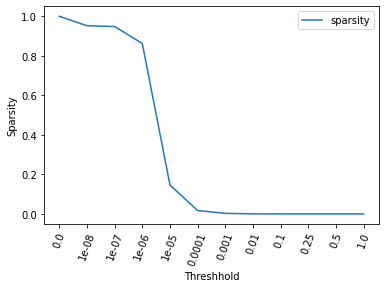

In [34]:
pd_res = []
for i, t in enumerate(thresh):
  print(i,t,np.mean(res[i]))
  pd_res.append([t,round(np.mean(res[i])/68304,5), np.mean(res[i])])

pdf = pd.DataFrame(pd_res, columns=["threshhold","sparsity","avg_num_types"])   #TODO label x axis with threshhold   <--- NOW and legend , and then do e2e to see if difference
#pdf.plot()

ax = pdf[["sparsity"]].plot(xticks=pdf.index, rot=70,xlabel="Threshhold", ylabel="Sparsity")
_ = ax.set_xticklabels(pdf["threshhold"])


In [35]:
# LOOK AT e2e results
print("Passing Entity Types through sigmoid", e2e_ets.shape)  #(20, 68304)
e2e_ets_sig = loc_sigmoid(e2e_ets)
print("Getting ordered probs for each test cases entity types")
e2e_probs = get_topk_types_v2(e2e_ets_sig, threshhold=.00000001)  # implied threshhold of .01
print(len(e2e_probs), len(e2e_probs[0]))      #20 68304

i = 15
final_types = show_types(i, combined_df, e2e_probs[i], threshhold=.1, printout=True)

final_types

Passing Entity Types through sigmoid (20, 68304)
Getting ordered probs for each test cases entity types
20 68304
Test Case 15
-----------------------------------
sentence1 In myelopoiesis, miR-223 has been shown to regulate granulocyte development in both humans and mice.
sentence2 As shown previously, miR-223 is highly conserved, and its myeloid-specific expression is also well characterized in both human and mouse
True score 3.6 vs Predicted:  [1.7043779]
-----------------------------------
Entity Types:
0 (0.9904999, 'scientific_control') 212
1 (0.98533857, 'basic_helix-loop-helix') 2999
2 (0.9848963, 'neuromodulation') 8894
3 (0.9782598, 'leukemia') 238
4 (0.9779765, 'hematopoietic_stem_cell') 1755
5 (0.97054905, 'haematopoiesis') 193
6 (0.9686452, 'market structure') 7600
7 (0.9663481, 'public economics') 6054
8 (0.96497893, 'transcription_(genetics)') 178
9 (0.9625139, 'motorcycle') 1039
10 (0.9578692, 'administrative law') 3683
11 (0.9542825, 'lymphocyte') 112
12 (0.95258033, 'l

[(0.9904999, 'scientific_control'),
 (0.98533857, 'basic_helix-loop-helix'),
 (0.9848963, 'neuromodulation'),
 (0.9782598, 'leukemia'),
 (0.9779765, 'hematopoietic_stem_cell'),
 (0.97054905, 'haematopoiesis'),
 (0.9686452, 'market structure'),
 (0.9663481, 'public economics'),
 (0.96497893, 'transcription_(genetics)'),
 (0.9625139, 'motorcycle'),
 (0.9578692, 'administrative law'),
 (0.9542825, 'lymphocyte'),
 (0.95258033, 'law reform'),
 (0.9522985, 'economic liberalization'),
 (0.94994867, 'economics of regulation'),
 (0.91433036, 'microrna'),
 (0.8801298, 'gland'),
 (0.86727417, 'public policy'),
 (0.8640614, 'gene_cluster'),
 (0.8554758, 'trans_fat'),
 (0.8329521, 'transcription_factor'),
 (0.8329203, 'thymus'),
 (0.8148387, 'mouse'),
 (0.8137006, 'human_serum_albumin'),
 (0.8028321, 'pain'),
 (0.79791945, 'hnf1b'),
 (0.7913714, 'cell_cycle'),
 (0.78643525, 'long_hair'),
 (0.7821915, 'english-language television programs'),
 (0.7473372, 'lymphocytes'),
 (0.7464984, 'cdc25'),
 (0.73

In [36]:
num_ets = []
thresh = [0, .00000001, .0000001, .000001, .00001, .0001, .001, .01, .1, .25, .5, 1]
e2e_res = []
for t in thresh:
  loc_res = []
  for i, r in enumerate(e2e_probs):
    loc_res.append(sum([1 for v in r if v[0] >= t ]))
  e2e_res.append(loc_res)

0 0 68304.0
1 1e-08 68302.9
2 1e-07 68298.8
3 1e-06 68273.75
4 1e-05 68069.95
5 0.0001 66314.1
6 0.001 44794.55
7 0.01 5723.2
8 0.1 780.3
9 0.25 329.7
10 0.5 138.8
11 1 0.0


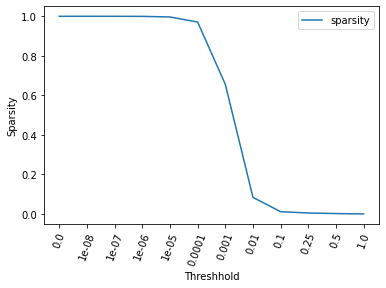

In [37]:
epd_res = []
for i, t in enumerate(thresh):
  print(i,t,np.mean(e2e_res[i]))
  epd_res.append([t,round(np.mean(e2e_res[i])/68304,5), np.mean(e2e_res[i])])

epdf = pd.DataFrame(epd_res, columns=["threshhold","sparsity","avg_num_types"])   #legend 
#pdf.plot()

ax = epdf[["sparsity"]].plot(xticks=epdf.index, rot=70,xlabel="Threshhold", ylabel="Sparsity")
_ = ax.set_xticklabels(epdf["threshhold"])


In [38]:
pdf.columns = ["threshhold", "ffn_sparsity","ffn_avg_num_types"]
epdf.columns = ["threshhold_x", "e2e_sparsity","e2e_avg_num_types"]
comb_e2e_ffn_df = pd.concat([pdf, epdf], axis = 1)
comb_df = comb_e2e_ffn_df[["threshhold", "ffn_sparsity","ffn_avg_num_types","e2e_sparsity", "e2e_avg_num_types"]]
#comb_df = comb_e2e_ffn_df
comb_df[["threshhold", "ffn_avg_num_types", "e2e_avg_num_types","ffn_sparsity","e2e_sparsity",]].head(12)

,threshhold,ffn_avg_num_types,e2e_avg_num_types,ffn_sparsity,e2e_sparsity
0,0.000000e+00,68304.00,68304.00,1.00000,1.00000
1,1.000000e-08,65052.05,68302.90,0.95239,0.99998
2,1.000000e-07,64757.60,68298.80,0.94808,0.99992
3,1.000000e-06,58905.95,68273.75,0.86241,0.99956
4,1.000000e-05,9981.55,68069.95,0.14613,0.99657
5,1.000000e-04,1190.00,66314.10,0.01742,0.97087
6,1.000000e-03,202.35,44794.55,0.00296,0.65581
7,1.000000e-02,33.60,5723.20,0.00049,0.08379
8,1.000000e-01,8.10,780.30,0.00012,0.01142
9,2.500000e-01,4.35,329.70,0.00006,0.00483


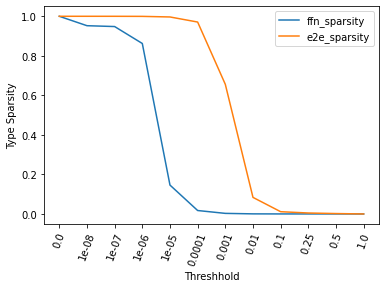

In [39]:
#comb_df.plot()
from matplotlib import pyplot as plt

ax = comb_df[["ffn_sparsity","e2e_sparsity"]].plot(xticks=epdf.index, rot=70,xlabel="Threshhold", ylabel="Type Sparsity")
_ = ax.set_xticklabels(comb_df["threshhold"])
plt.savefig('line_plot_tight.pdf',bbox_inches="tight")  

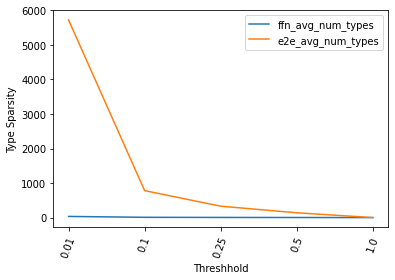

In [40]:
i = 7
ax = comb_df[i:][["ffn_avg_num_types","e2e_avg_num_types"]].plot(xticks=epdf.index[i:], rot=70,xlabel="Threshhold", ylabel="Type Sparsity")
_ = ax.set_xticklabels(comb_df["threshhold"][i:])